# Yu, Gutnisky et al., 2016 - A DataJoint example
This notebook presents data and results associated with the following papers:

>Jianing Yu, Diego A Gutnisky, S Andrew Hires & Karel Svoboda1. "Layer 4 fast-spiking interneurons filter thalamocortical signals during active somatosensation" (2016) Nat Neurosci (https://dx.doi.org/10.1038/nn.4412)

In this study, membrane potential and spikes recordings were performed ventral posteromedial nucleus (VPM) neurons and layer 4 (L4) neurons of the barrel cortex, during an object-locating with whiskers task. The study reported a movement-related suppression mechanism of the thalamocortical circuit. Specifically, the L4 fast-spiking interneurons, inherited from the sensory input driven VPM activity, suppressed movement-related activity of the L4 excitatory neurons. This movement-related suppression thus improved selectivity for touch-related information during active tactile sensation.

A ***DataJoint*** data pipeline has been constructed for this study, with the presented data ingested into this pipeline. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper. From the pipeline, export capability to NWB 2.0 format is also available.

## About the data

Data consists of membrane potential, extracellular recordings and spike sorted results of the mouse's VPM and L4 neurons a whisker-based object locating task. The behavior data includes detailed description of the trial structure (e.g. trial timing, trial instruction, trial response, etc.), lick trace data and a variety of whisker movement related tracking data: whisker angle, whisker curavture, touch times, etc. Trial information also includes optogenetic photostimulation details.

Original data shared here: http://crcns.org/data-sets/ssc/ssc-7

The data in original NWB 1 format (.nwb) have been ingested into a DataJoint data pipeline presented below. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper.

Data are also exported into NWB 2.0 format. See NWB export code [here](../scripts/datajoint_to_nwb.py)

In [1]:
# import necessary Python packages including DataJoint

from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis, virus,
                      intracellular, extracellular, behavior, utilities)

Connecting root@127.0.0.1:3306


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline 

## Architecture of the data pipeline

This data pipeline is comprised of three core components:
+ **subject**: the meta information on the animal, e.g. genetic information, virus injection
+ **acquisition**: the organization of the experiment: session acquisition, trial structure, behavior data
+ **electrophysiology**: intracellular and extracellular recordings, as well as spike sorted results

In DataJoint, related tables are organized together into a **schema**, and a data pipeline typically consists of tables across multiple schemas connected to each other.

### Subject

`subject` schema contains various tables representing information and meta-information about the experimental animals, as well as information about genetic backgrounds and virus injected for the experiment. The DataJoint *Diagram* below shows all tables found inside the `subject` schema.

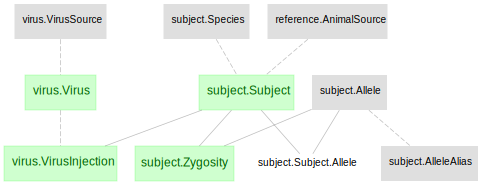

In [10]:
dj.Diagram(subject) - 1 + dj.Diagram(virus)

For example, `Subject` table contains information about each and every mouse in the experiment, capturing information such as unique subject ID and animal sourcce.

In [19]:
subject.Subject()

subject_id id of the subject (e.g. ANM244028),species,"animal_source source of the animal, Jax, Charles River etc.",sex,date_of_birth,subject_description
anm184389,Mus musculus,Jackson,M,None,None
anm186997,Mus musculus,Jackson,M,None,None
anm190963,Mus musculus,GENSAT,F,2012-10-14,None
anm190964,Mus musculus,GENSAT,F,2012-10-14,None
anm196837,Mus musculus,GENSAT,F,2012-12-05,None
anm199549,Mus musculus,Jackson,M,None,None
anm199551,Mus musculus,Jackson,F,None,None


### Experiment acquisition

Information pertaining to conducting the experiment as well as data and meta-data acquired during the experiment (except for electrophysiology) are found among three schemas: `acquisition`, `stimulation` and `behavior`. Below, tables across all three schemas are depicted in the DataJoint Diagram.

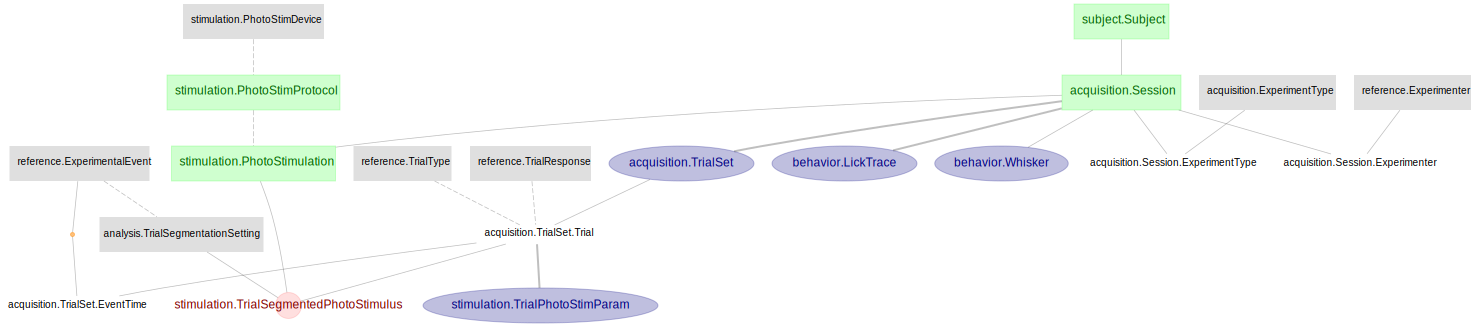

In [9]:
dj.Diagram(acquisition) - 1 + dj.Diagram(stimulation) + dj.Diagram(behavior)

`Session` tables contains information about individual experiment session.

In [12]:
acquisition.Session.proj() * subject.Subject

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,species,"animal_source source of the animal, Jax, Charles River etc.",sex,date_of_birth,subject_description
anm184389,2013-02-07 00:00:00,ANM184389_20130207,Mus musculus,Jackson,M,None,None
anm184389,2013-02-11 00:00:00,ANM184389_20130211,Mus musculus,Jackson,M,None,None
anm184389,2013-02-12 00:00:00,ANM184389_20130212,Mus musculus,Jackson,M,None,None
anm184389,2013-02-13 00:00:00,ANM184389_20130213,Mus musculus,Jackson,M,None,None
anm186997,2013-03-17 00:00:00,ANM186997_20130317,Mus musculus,Jackson,M,None,None
anm186997,2013-03-21 00:00:00,ANM186997_20130321,Mus musculus,Jackson,M,None,None
anm190963,2013-04-08 00:00:00,JY0520AAAC,Mus musculus,GENSAT,F,2012-10-14,None


`Trial` table (found as part table of `TrialSet`) contains information about each trial.

In [14]:
acquisition.TrialSet.Trial()

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,trial_id id of this trial in this trial set,"start_time start time of this trial, with respect to starting point of this session","stop_time end time of this trial, with respect to starting point of this session",trial_type,trial_response,trial_stim_present is this a stim or no-stim trial,pole_position (um) the location of the pole along the anteroposterior axis of the animal
anm184389,2013-02-07 00:00:00,ANM184389_20130207,1,0.0,5.0,Go,Miss,0,nan
anm184389,2013-02-07 00:00:00,ANM184389_20130207,2,5.0,10.0,Go,Miss,0,nan
anm184389,2013-02-07 00:00:00,ANM184389_20130207,3,10.0,15.0,Go,Miss,0,nan
anm184389,2013-02-07 00:00:00,ANM184389_20130207,4,15.0,20.0,Go,Miss,0,nan
anm184389,2013-02-07 00:00:00,ANM184389_20130207,5,20.0,25.0,Go,Miss,0,nan
anm184389,2013-02-07 00:00:00,ANM184389_20130207,6,25.0,30.0,Go,Miss,0,nan
anm184389,2013-02-07 00:00:00,ANM184389_20130207,7,30.0,35.0,Go,Miss,0,nan


### Electrophysiology

Electrophysiology information are found among two related schemas: `extracellular` and `intracellular`.

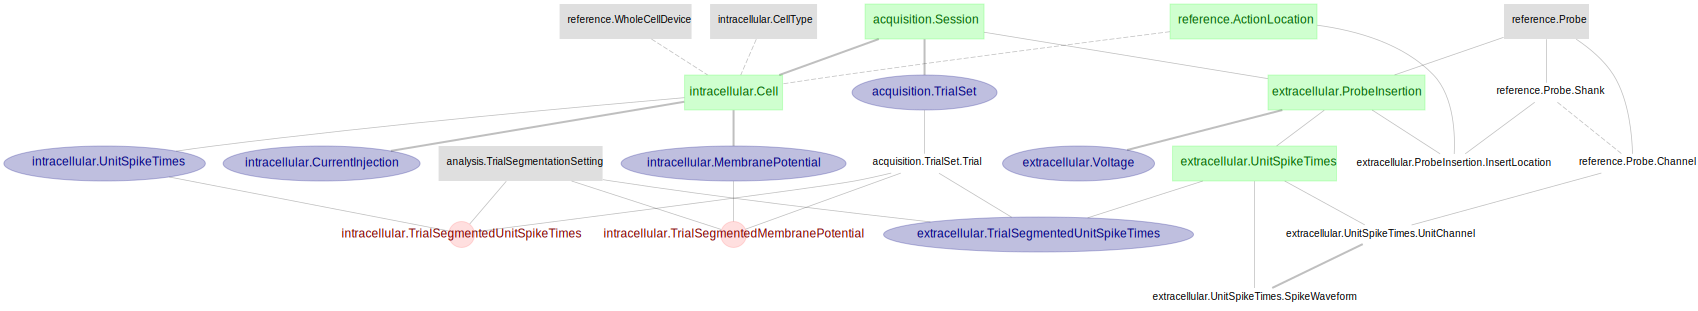

In [7]:
(dj.Diagram(extracellular) - 1) + (dj.Diagram(intracellular) - 1)

The Unit table

As an example, `extracellular.UnitSpikeTimes` table contains information about each and every sorted units and their associated spike trains (in the form of unit spike times).

In [17]:
extracellular.UnitSpikeTimes * extracellular.ProbeInsertion.InsertLocation 

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,probe_name String naming probe model,channel_counts number of channels in the probe,unit_id,shank_id the shank id of this probe this channel is located on,brain_region,brain_subregion,cortical_layer layer within cortex,hemisphere,coordinate_ref,"coordinate_ap in mm, anterior positive, posterior negative","coordinate_ml in mm, always postive, number larger when more lateral","coordinate_dv in mm, always postive, number larger when more ventral (deeper)","spike_times (s) time of each spike, with respect to the start of session",cell_desc e.g. description of this unit (e.g. cell type)
anm184389,2013-02-07 00:00:00,ANM184389_20130207,4x8_Neuronexus_Z50um_X200um,32,1,0,thalamus,VPM,N/A,left,bregma,0.00,0.00,2.50,=BLOB=,thalamic. Unit: #3.1.58
anm184389,2013-02-07 00:00:00,ANM184389_20130207,4x8_Neuronexus_Z50um_X200um,32,2,0,thalamus,VPM,N/A,left,bregma,0.00,0.00,2.50,=BLOB=,thalamic. Unit: #3.3.33
anm184389,2013-02-07 00:00:00,ANM184389_20130207,4x8_Neuronexus_Z50um_X200um,32,3,0,thalamus,VPM,N/A,left,bregma,0.00,0.00,2.50,=BLOB=,thalamic. Unit: #3.4.148
anm184389,2013-02-11 00:00:00,ANM184389_20130211,4x8_Neuronexus_Z50um_X200um,32,1,0,thalamus,VPM,N/A,left,bregma,0.00,0.00,2.50,=BLOB=,thalamic. Unit: #4.4.46
anm184389,2013-02-11 00:00:00,ANM184389_20130211,4x8_Neuronexus_Z50um_X200um,32,2,0,thalamus,VPM,N/A,left,bregma,0.00,0.00,2.50,=BLOB=,thalamic. Unit: #4.4.57
anm184389,2013-02-12 00:00:00,ANM184389_20130212,4x8_Neuronexus_Z50um_X200um,32,1,0,thalamus,VPM,N/A,left,bregma,0.00,0.00,2.50,=BLOB=,thalamic. Unit: #5.1.56
anm184389,2013-02-12 00:00:00,ANM184389_20130212,4x8_Neuronexus_Z50um_X200um,32,2,0,thalamus,VPM,N/A,left,bregma,0.00,0.00,2.50,=BLOB=,thalamic. Unit: #5.4.142


## Reproduced analysis and figures

To demonstrate the availability and usage of the data in the pipeline, the following sections of this notebook will show the extraction and plotting of several sets of tracking and ephys data of interest, specifically, we will reproduce ***Figure 1*** and ***Figure 2*** of this study.

Figure 1 and 2 depict the behavior and electrophysiology data of VPM and L4 excitatory neurons over the course of an experimental trial, as well as trial-averaged membrane potential and spike rate. To reproduce these figures, the following steps are taken:
1. extract ephys and behavioral data:
    + membrane potential
    + spikes
    + whisker movement
    + touch trace
2. plot these data, per trial, time-locked to trial-start
3. extract touch times
4. perform trial segmentation and realignment of ephys data to touch times
5. plot spike raster, trial-averaged membrane potential and spike histogram

To accomplish those steps, we define 3 utility functions to help with extracting and segmenting data:
+ ***segment_timeseries*** - segment any timeseries (e.g. Vm, lick traces) or event-series (e.g. spike times) to some specified time (e.g. trial start time or first touch time)
+ ***build_raster_and_PSTH*** - from spike times, compute PSTH
+ ***build_trial_segmented_timeseries*** - the main processing routine, to extract Vm, behavioral data, spikes, etc. and segment, aligned to i) trial-start and ii) touch onset

and 2 plotting functions:
+ ***plot_trial_start_align*** - plot behavioral and ephys daata from a single trial, aligned to trial-start time
+ ***plot_touch_aligned*** - plot trial aggregated behavioral, ephys, and spike PSTH, aligned to first touch onset

In [4]:
def segment_timeseries(data, timestamps, event_times, pre_dur, post_dur):
    d_seg = [data[np.logical_and(timestamps > t - pre_dur, timestamps <= t + post_dur)] for t in event_times]
    t_seg = [timestamps[np.logical_and(timestamps > t - pre_dur, timestamps <= t + post_dur)] - t for t in event_times]
    return d_seg, t_seg

In [5]:
# trial-average spike histogram
def build_raster_and_PSTH(spike_times, timerange, bin_size=0.05):
    stacked_spikes = np.hstack(spike_times)
    stacked_trials = np.hstack([np.full_like(r, idx) if r.size > 0 else [] for idx, r in enumerate(spike_times)])
    spk_counts, spk_edges = np.histogram(stacked_spikes, bins=int((timerange[-1] - timerange[0]) / bin_size), range=timerange)
    spk_rates = spk_counts / np.diff(spk_edges) / len(spike_times)
    return stacked_spikes, stacked_trials, spk_rates, spk_edges[:-1]

In [6]:
def build_trial_segmented_timeseries(session_key):
    trial_start, trial_stop = (acquisition.TrialSet.Trial & session_key).fetch('start_time', 'stop_time')
    
    # ==== Step 1 - get behavioral data from the principal whisker ====
    dis_to_pole, touch_on, touch_off, whisk_pos, whisk_curv, b_tvec = (behavior.Whisker 
                                                                       & session_key
                                                                       & 'principal_whisker=1').fetch1(
        'distance_to_pole', 'touch_onset', 'touch_offset', 'whisker_angle', 'whisker_curvature', 'behavior_timestamps')
    
    touch_on = np.where(touch_on==1, touch_on, np.nan)
    touch_off = np.where(touch_off==1, touch_off, np.nan)
    
    if extracellular.UnitSpikeTimes & session_key:
        spike_times = (extracellular.UnitSpikeTimes & session_key).fetch1('spike_times')
    elif intracellular.UnitSpikeTimes & session_key:
        spike_times = (intracellular.UnitSpikeTimes & session_key).fetch1('spike_times')
    
    lick_traces, l_tvec = (behavior.LickTrace & session_key).fetch1('lick_trace', 'lick_trace_timestamps')
    
    # ==== Step 2 - align to trial start ====
    # segment: 0 to 5s of trial_start
    event_times = trial_start
    pre_dur = 0
    post_dur = 5
    b_fs = round(1/np.median(np.diff(b_tvec)))
    
    segmented_spikes = [spike_times[np.logical_and(spike_times > t - pre_dur, 
                                               spike_times <= t + post_dur)] - t for t in event_times]
    segmented_lick_traces, segmented_ltvec = segment_timeseries(lick_traces, l_tvec, event_times, pre_dur, post_dur)
    segmented_behav = {k: segment_timeseries(d, b_tvec, event_times, pre_dur, post_dur)[0]
                   for k, d in zip(('touch_on', 'touch_off', 'whisk_pos', 'whisk_curv'), 
                                   (touch_on, touch_off, whisk_pos, whisk_curv))}
    segmented_btvec = segment_timeseries(whisk_pos, b_tvec, event_times, pre_dur, post_dur)[1]
    
    trial_start_aligned = {'pre_start': pre_dur, 'post_start':post_dur, 'spikes': segmented_spikes,
                           'licks': segmented_lick_traces, 'lick_times': segmented_ltvec,
                           'whiskers': segmented_behav, 'whisker_times': segmented_btvec}
    
    if intracellular.MembranePotential & session_key:
        Vm, v_tvec = (intracellular.MembranePotential & cell_key).fetch1('membrane_potential', 'membrane_potential_timestamps')
        segmented_Vm, segmented_vtvec = segment_timeseries(Vm, v_tvec, event_times, pre_dur, post_dur)
        trial_start_aligned.update(Vm=segmented_Vm, Vm_times=segmented_vtvec)
    
    # ==== Step 3 - align to touch onsets ====
    # touch times
    touch_onset = b_tvec[touch_on==1]
    touch_offset = b_tvec[touch_off==1]
    # inter-touch-interval - of each touch
    iti = (touch_onset[1:] - touch_offset[:-1]) 
    
    # get touch-onset that has inter-touch-interval of at least 25ms
    touch_onset = touch_onset[:-1][iti > 25e-3]
    # segment: -25ms to 50ms of touch-time
    pre_touch = 25e-3
    post_touch = 50e-3
    # touch-aligned spike-times
    touch_aligned_spikes = [spike_times[np.logical_and(spike_times > t_touch - pre_touch, 
                                                       spike_times < t_touch + post_touch)] - t_touch
                            for t_touch in touch_onset]
    # touch-aligned Whisker Curvature
    touch_aligned_curvature, touch_aligned_btvec = segment_timeseries(whisk_curv, b_tvec, touch_onset, pre_touch, post_touch)
    touch_aligned_curvature = [np.where((k - k[:100].mean()) < 0, k - k.mean(), 0) for k in touch_aligned_curvature]
    
    # psth
    stacked_spikes, stacked_trials, spk_rates, spk_edges = build_raster_and_PSTH(
        touch_aligned_spikes, (-pre_touch, post_touch), bin_size=0.001)
    
    touch_aligned = {'pre_touch': pre_touch, 'post_touch':post_touch, 'spikes': touch_aligned_spikes,
                     'whisk_curv': touch_aligned_curvature, 'whisker_times': touch_aligned_btvec,
                     'stacked_spikes': stacked_spikes, 'stacked_trials': stacked_trials,
                     'spk_rates': spk_rates, 'spk_edges': spk_edges}
    
    if intracellular.MembranePotential & session_key:
        # touch-aligned Vm
        touch_aligned_Vm, touch_aligned_vtvec = segment_timeseries(Vm, v_tvec, touch_onset, pre_touch, post_touch)
        touch_aligned.update(Vm=touch_aligned_Vm, Vm_times=touch_aligned_vtvec)
    
    return trial_start_aligned, touch_aligned

In [7]:
def plot_trial_start_aligned(trial_num, trial_start_aligned):
    pre_dur = trial_start_aligned['pre_start']
    post_dur = trial_start_aligned['post_start']
    l_tvec = trial_start_aligned['lick_times'][trial_num]
    licks = trial_start_aligned['licks'][trial_num]
    b_tvec = trial_start_aligned['whisker_times'][trial_num]
    whisk_curv = trial_start_aligned['whiskers']['whisk_curv'][trial_num]
    touch_on = trial_start_aligned['whiskers']['touch_on'][trial_num]
    whisk_pos = trial_start_aligned['whiskers']['whisk_pos'][trial_num]
    spikes = trial_start_aligned['spikes'][trial_num]
    
    
    if 'Vm' in trial_start_aligned:
        fig, axs = plt.subplots(5, 1, figsize=(12, 6))
        fig.subplots_adjust(hspace=0.01)
        
        for x in b_tvec[touch_on==1]:
            axs[3].axvline(x, 0.25, 0.75, color='deepskyblue')
        axs[3].plot(trial_start_aligned['Vm_times'][trial_num], trial_start_aligned['Vm'][trial_num], 'k')
        axs[4].plot(b_tvec, whisk_pos, 'g')
        axs[4].plot(b_tvec, whisk_pos * touch_on, '.', c='deepskyblue')
            
    else:
        fig, axs = plt.subplots(4, 1, figsize=(12, 6))
        fig.subplots_adjust(hspace=0.01)
        
        for x in b_tvec[touch_on==1]:
            axs[2].axvline(x, 0.25, 0.75, color='deepskyblue')
        axs[3].plot(b_tvec, whisk_pos, 'g')
        axs[3].plot(b_tvec, whisk_pos * touch_on, '.', c='deepskyblue')

    axs[0].plot(l_tvec, np.where(licks > 0, licks, np.nan), '.', color='deeppink')
    axs[1].plot(b_tvec, whisk_curv, 'deepskyblue')
    for x in spikes:
        axs[2].axvline(x, 0.35, 0.65, color='k')
    
    for a in axs:
        a.set_xlim((-pre_dur, post_dur))
        a.spines['right'].set_visible(False)
        a.spines['top'].set_visible(False)
        a.spines['left'].set_visible(False)
        a.spines['bottom'].set_visible(False)
        a.set_yticks([])
        a.set_xlim((0.5, 2))
    for a in axs[:-1]:
        a.set_xticks([])

In [8]:
def plot_touch_aligned(touch_aligned):
    pre_dur = touch_aligned['pre_touch']
    post_dur = touch_aligned['post_touch']
    b_tvec = touch_aligned['whisker_times']
    whisk_curv = touch_aligned['whisk_curv']
    stacked_spikes = touch_aligned['stacked_spikes']
    stacked_trials = touch_aligned['stacked_trials']
    spk_rates = touch_aligned['spk_rates']
    spk_edges = touch_aligned['spk_edges']
    
    if 'Vm' in trial_start_aligned:
        fig, axs = plt.subplots(4, 1, figsize=(4, 8))
        rand_trials = np.random.randint(len(touch_aligned['Vm']), size=20)
        for k in rand_trials:
            axs[2].plot(touch_aligned['Vm_times'][k], touch_aligned['Vm'][k], color='gray', alpha=0.2)
        axs[3].bar(spk_edges, spk_rates, width=0.001, color='k')
    else:
        fig, axs = plt.subplots(3, 1, figsize=(4, 6))

        axs[2].bar(spk_edges, spk_rates, width=0.001, color='k')
        
    # pick 20 random trials to plot
    rand_trials = np.random.randint(len(whisk_curv), size=20)
    for k in rand_trials:
        axs[0].plot(b_tvec[k], whisk_curv[k], color='b', alpha=0.5)
    rand_trials = np.random.randint(len(stacked_spikes), size=40)
    axs[1].plot(stacked_spikes[rand_trials], stacked_trials[rand_trials], '|', color='k')
        
    # cosmetic
    for a in axs[:-1]:
        a.set_axis_off()
        a.set_xlabel([])
        a.set_xlim((-pre_dur, post_dur))

    for a in axs[1:]:
        a.axvline(x=0, color='b')
        a.set_xlim((-pre_dur, post_dur))

    axs[-1].set_xlabel('Time from touch onset')
    axs[-1].spines["top"].set_visible(False)
    axs[-1].spines["right"].set_visible(False)

## Replication of Figure 1 (b, d) - VPM

Here, we plot the trial-aligned behavior and ephys data from one representative trial. 

Specifically, we plot ephys, spike, and PSTH for 3 cells:
+ ANM199549_20130530
+ ANM199552_20130602
+ ANM186997_20130321

One session represents the recording of one neuron, thus the `session_id` also uniquely depicts a cell

In [20]:
session_key = acquisition.Session & 'session_id = "ANM199549_20130530"'

In [27]:
extracellular.UnitSpikeTimes * extracellular.ProbeInsertion & session_key

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,probe_name String naming probe model,channel_counts number of channels in the probe,unit_id,"spike_times (s) time of each spike, with respect to the start of session",cell_desc e.g. description of this unit (e.g. cell type)
anm199549,2013-05-30 00:00:00,ANM199549_20130530,4x8_Neuronexus_Z50um_X200um,32,1,=BLOB=,thalamic. Unit: #14.3.244


Using the selected `session_key`, we extract the behavioral and ephys data of interest, calling the `build_trial_segmented_timeseries()` helper function defined above.

In [ ]:
trial_start_aligned, touch_aligned = build_trial_segmented_timeseries(session_key)

#### Plot behavioral and ephys data for one representative trial (trial 348)
Invoke the `plot_trial_start_aligned()` defined above

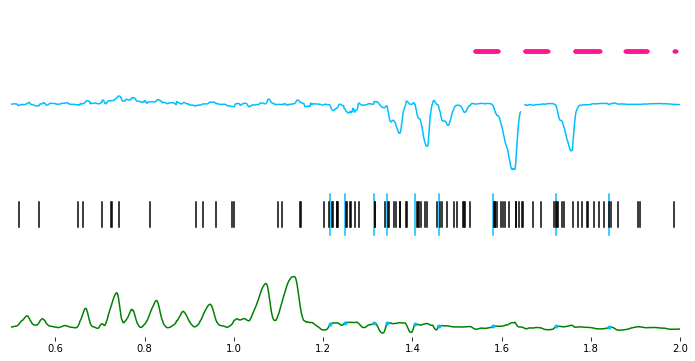

In [13]:
plot_trial_start_aligned(348, trial_start_aligned)

#### Plot touch-aligned spike raster and spike histogram

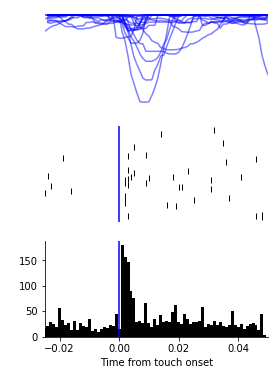

In [29]:
plot_touch_aligned(touch_aligned)

#### Repeat the plots for other neurons

In [30]:
session_key = acquisition.Session & 'session_id = "ANM199552_20130602"'
trial_start_aligned, touch_aligned = build_trial_segmented_timeseries(session_key)

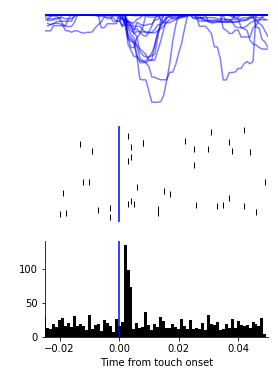

In [35]:
plot_touch_aligned(touch_aligned)

In [36]:
session_key = acquisition.Session & 'session_id = "ANM186997_20130321"'
trial_start_aligned, touch_aligned = build_trial_segmented_timeseries(session_key)

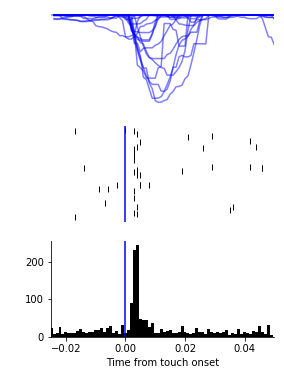

In [42]:
plot_touch_aligned(touch_aligned)

## Replication of Figure 2 (b, d) - L4 excitatory cell

The actual implementation here is almost identical to that of Figure 1 above, which revolves around selecting one `cell` key, and invoking the utility functions defined above to actually plot the data.

We plot the trial-aligned behavior and ephys data from one representative trial, plotting ephys, spike, and PSTH for 3 cells:
+ JY0861AAAA
+ JY0520AAAC
+ JY1008AAAA

Snippet of the pipeline architecture around **intracellular** schema

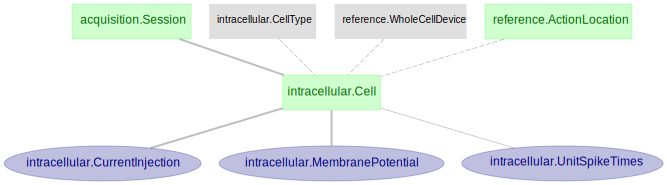

In [30]:
dj.Diagram(intracellular.Cell) + 1 - 1

In [43]:
cell_key = intracellular.Cell & {'session_id': 'JY0861AAAA'}
trial_start_aligned, touch_aligned = build_trial_segmented_timeseries(cell_key)

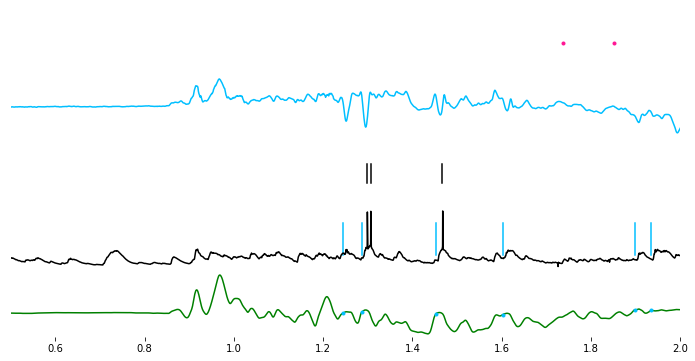

In [44]:
plot_trial_start_aligned(20, trial_start_aligned)

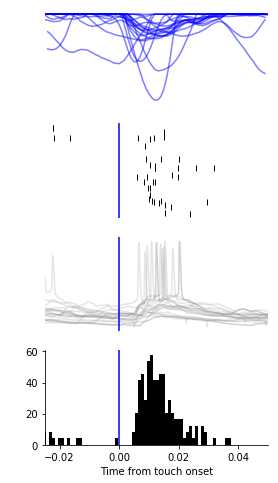

In [48]:
plot_touch_aligned(touch_aligned)

In [50]:
cell_key = intracellular.Cell & {'session_id': 'JY0520AAAC'}
trial_start_aligned, touch_aligned = build_trial_segmented_timeseries(cell_key)

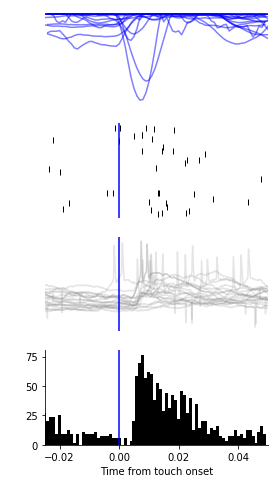

In [78]:
plot_touch_aligned(touch_aligned)

In [79]:
cell_key = intracellular.Cell & {'session_id': 'JY1008AAAA'}
trial_start_aligned, touch_aligned = build_trial_segmented_timeseries(cell_key)

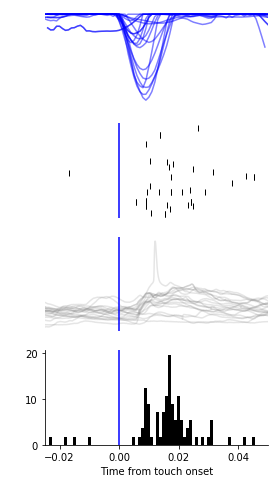

In [82]:
plot_touch_aligned(touch_aligned)